In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Bidirectional, Lambda
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from tf2crf import CRF, ModelWithCRFLoss

In [39]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Token"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["BIO_tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Record Number").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [60]:
def get_model_list(f, delim="<|>"):
    with open(f,'r',encoding='utf-8') as f:
        d={}
        while True:
            try:
                line = f.readline()
                line = str(line).split(delim)
                d[str(line[0])]=int(str(line[1]).replace('\n',''))
            except:
                break
    f.close()
    return d

In [55]:
df = pd.read_csv("df_modified2.csv")

In [57]:
maxlen = max(len(s) for s in list(df['Title']))
maxlen

129

In [58]:
words = list(set(df['Token']))
tags = list(set(df['BIO_tag']))
pos = list(set(df['POS']))

In [59]:
getter=SentenceGetter(df)
sentences = getter.sentences

In [84]:
#coded embedding indexing
word2idx = get_model_list("train_words.txt")
pos2idx = get_model_list("pos_tags.txt")
tag2idx = get_model_list("bio_tags.txt")
char2idx = get_model_list("train_chars.txt")

In [62]:
max_len=128
max_len_char=128

In [63]:
X_word = [[word2idx[w[0]] if w[0] in word2idx.keys() else '1' for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [64]:
X_pos = [[pos2idx[w[1]] if w[1] in pos2idx.keys() else '1' for w in s] for s in sentences]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')

In [87]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                if i>=len(sentence):
                    word_seq.append(char2idx["PAD"])
                elif j>=len(str(sentence[i][0])):
                    word_seq.append(char2idx["PAD"])
                elif not str(sentence[i][0][j]) in char2idx.keys():
                    word_seq.append(char2idx["UNK"])
                else:
                    word_seq.append(char2idx['PAD'])
                    
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
XX_char = np.asarray(X_char).astype("float")
XX_char = np.where(XX_char==None, 1, XX_char)

In [88]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [89]:
X_train_w, X_test_w, y_train, y_test = train_test_split(X_word, y, test_size=0.1, random_state=1234)
X_train_pos, X_test_pos, _, _ = train_test_split(X_pos, y, test_size=0.1, random_state=1234)
X_train_char, X_test_char, _, _ = train_test_split(XX_char, y, test_size=0.1, random_state=1234)

In [90]:
#train_input = [X_train_w, X_train_pos, X_train_char]
train_input = [X_word, X_pos, XX_char]

In [91]:
#----------Model Setup----------

#-----Input Setup-----
# embedding for words
word_input = Input(shape=(max_len,), name="Word_Inputs")
emb_word = Embedding(input_dim=len(word2idx)+1, output_dim=64, input_length=max_len, mask_zero=True, name="Word_Embed")(word_input)

# embedding for parts of speech
pos_input = Input(shape=(max_len,), name="POS_Inputs")
emb_pos = Embedding(input_dim=len(pos2idx)+1, output_dim=32, input_length=max_len, mask_zero=True, name="POS_Embed")(pos_input)

# embedding for chars
char_input = Input(shape=(max_len, max_len_char,), name="Char_Inputs")
emb_char = TimeDistributed(Embedding(input_dim=max_len_char+, output_dim=32,input_length=max_len_char, mask_zero=True, name="Char_Embed"), name="Char_Time_Dist")(char_input)
char_enc = TimeDistributed(LSTM(units=32, return_sequences=False, recurrent_dropout=0.2), name="Char_LSTM_Enc")(emb_char)

#Input Concat
x = concatenate([emb_word, emb_pos, char_enc], name="Main_Input")
x = SpatialDropout1D(0.2, name="Main_Dropout")(x)

#-----LSTM-----
x = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2,name="LSTM_1"))(x)
x_rnn = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2,name="LSTM_2"))(x)
x = add([x, x_rnn])  

#out = TimeDistributed(Dense(len(tag2idx)+1, activation="softmax",name="Dense_Output"))(x)

crf = CRF(units=9, type='float32')
out = crf(x)
base = Model([word_input,pos_input,char_input], out, name="Model_2.4")
model = Model([word_input, pos_input, char_input], out, name='Model_2.3')



In [92]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "Model_2.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Char_Inputs (InputLayer)       [(None, 128, 128)]   0           []                               
                                                                                                  
 Word_Inputs (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 POS_Inputs (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 Char_Time_Dist (TimeDistribute  (None, 128, 128, 32  4128       ['Char_Inputs[0][0]']            
 d)                             )                                                         

In [93]:
tf.config.run_functions_eagerly(True)

In [94]:
history = model.fit(train_input,
                    np.array(y).reshape(len(y), max_len, 1),
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.1, 
                    verbose=1)

Epoch 1/12
127/127 [==============================] - 9697s 76s/step - loss: 0.2556 - acc: 0.4117 - val_loss: 0.2341 - val_acc: 0.6389
Epoch 2/12
127/127 [==============================] - 8016s 63s/step - loss: 0.0991 - acc: 0.7603 - val_loss: 0.1038 - val_acc: 0.8337
Epoch 3/12
127/127 [==============================] - 8140s 64s/step - loss: 0.0532 - acc: 0.8693 - val_loss: 0.0653 - val_acc: 0.8961
Epoch 4/12
127/127 [==============================] - 8803s 69s/step - loss: 0.0364 - acc: 0.9077 - val_loss: 0.0493 - val_acc: 0.9189
Epoch 5/12
127/127 [==============================] - 7999s 63s/step - loss: 0.0277 - acc: 0.9274 - val_loss: 0.0403 - val_acc: 0.9292
Epoch 6/12
127/127 [==============================] - 7951s 63s/step - loss: 0.0217 - acc: 0.9411 - val_loss: 0.0368 - val_acc: 0.9341
Epoch 7/12
127/127 [==============================] - 8007s 63s/step - loss: 0.0181 - acc: 0.9505 - val_loss: 0.0357 - val_acc: 0.9333
Epoch 8/12
127/127 [==============================] - 7

In [95]:
model.save("./model/model_2.3")

INFO:tensorflow:Assets written to: ./model/model_2.3\assets


INFO:tensorflow:Assets written to: ./model/model_2.3\assets


In [96]:
hist = pd.DataFrame(history.history)

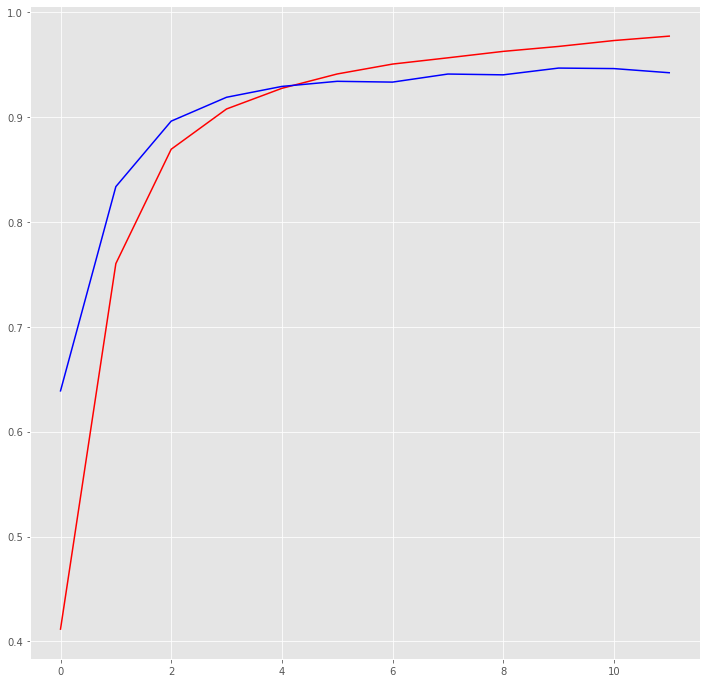

In [97]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.show()
